In [1]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, accuracy_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import cross_val_predict
from sklearn import metrics

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import string
import nltk
import re

nltk.download("stopwords")
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to C:\Users\Ethan
[nltk_data]     Smith\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to C:\Users\Ethan
[nltk_data]     Smith\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
df1 = pd.read_csv('commits1.csv')
df2 = pd.read_csv('commits2.csv')
df3 = pd.read_csv('commits3.csv')
df4 = pd.read_csv('commits4.csv')
df5 = pd.read_csv('commits5.csv')
df6 = pd.read_csv('commits6.csv')
df7 = pd.read_csv('commits7.csv')
commits = pd.concat([df1, df2, df3, df4, df5, df6, df7], ignore_index=True)

c2_cols = ['microsoft/azuredatastudio', 'xamarin/xamarin-macios', 'pingcap/docs']
c3_cols = ['umijs/umi', 'netbox-community/netbox', 'grafana/loki', 'awsdocs/aws-doc-sdk-examples', 'vueuse/vueuse',
     'yuzu-emu/yuzu', 'TanStack/query', 'lvgl/lvgl', 'arendst/Tasmota', 'Aircoookie/WLED']

In [3]:
def assign_cluster(value):
    if value in c2_cols:
        return 2
    elif value in c3_cols:
        return 3
    else:
        return 1

In [4]:
commits['Cluster'] = commits['name_with_owner'].apply(assign_cluster)
commits

,name_with_owner,author,message,is_core,Cluster
0,yuzu-emu/yuzu,lioncash,kernel/server_session: Return a std::pair from...,1,3
1,SamR1/FitTrackee,SamR1,store user picture w/ relative path instead of...,1,1
2,arendst/Tasmota,ascillato,Update xdrv_11_knx.ino,1,3
3,yuzu-emu/yuzu,FernandoS27,Correct Fermi Copy on Linear Textures.,1,3
4,pmmp/PocketMine-MP,dktapps,Plugin: Fixed return type documentation for ge...,1,1
...,...,...,...,...,...
458448,archesproject/arches,chrabyrd,Merge branch 'dev/7.5.x' of https://github.com...,1,1
458449,weaviate/weaviate,asdine,reduce duplicate lines,0,1
458450,weaviate/weaviate,donomii,.,0,1
458451,PhantomBot/PhantomBot,gmt2001,"Add follows, followed, and followedDate\nExpor...",1,1


In [5]:
commits['Cluster'].value_counts()

1    334851
3     93938
2     29664
Name: Cluster, dtype: int64

In [6]:
t1 = time.time()
# Initialize the stop words, the Porter stemmer, and the set of punctuation
stop_words = set(stopwords.words('english'))
porter = PorterStemmer()
punctuation_set = set(string.punctuation)

def is_english(word):
    # Check if all characters in the word are alphabetic (English)
    return all(char.isalpha() or char.isspace() for char in word)

def preprocess_text(text):
    # Check if the text is a valid string (not NaN)
    if isinstance(text, str):
        # Replace slashes, underscores, and dots with spaces
        text = text.replace('/', ' ').replace('_', ' ').replace('.', ' ')
        text = re.sub(r'([a-z])([A-Z])', r'\1 \2', text)
        # Create a translation table to remove punctuation within words
        translation_table = str.maketrans('', '', string.punctuation)

        # Tokenize the text
        words = word_tokenize(text)
        # Remove stop words, punctuation, and perform stemming
        filtered_words = [porter.stem(word.translate(translation_table)) for word in words if word not in stop_words]
        # Remove words containing non-English characters
        filtered_words = [word for word in filtered_words if is_english(word)]
        # Join the filtered words back into a string
        processed_text = ' '.join(filtered_words)
        return processed_text.strip().lower()  # Strip leading and trailing whitespaces
    else:
        return ''




# Apply the preprocessing function to the 'text' column
commits['processed_message'] = commits['message'].apply(preprocess_text)

print("Processed text in", round((time.time() - t1) / 60, 2), "Minutes")

Processed text in 1.69 Minutes


In [7]:
commits

,name_with_owner,author,message,is_core,Cluster,processed_message
0,yuzu-emu/yuzu,lioncash,kernel/server_session: Return a std::pair from...,1,3,kernel server session return std pair creat ...
1,SamR1/FitTrackee,SamR1,store user picture w/ relative path instead of...,1,1,store user pictur w rel path instead absolut path
2,arendst/Tasmota,ascillato,Update xdrv_11_knx.ino,1,3,updat xdrv knx ino
3,yuzu-emu/yuzu,FernandoS27,Correct Fermi Copy on Linear Textures.,1,3,correct fermi copi linear textur
4,pmmp/PocketMine-MP,dktapps,Plugin: Fixed return type documentation for ge...,1,1,plugin fix return type document get resourc
...,...,...,...,...,...,...
458448,archesproject/arches,chrabyrd,Merge branch 'dev/7.5.x' of https://github.com...,1,1,merg branch dev x http github com archesproj...
458449,weaviate/weaviate,asdine,reduce duplicate lines,0,1,reduc duplic line
458450,weaviate/weaviate,donomii,.,0,1,
458451,PhantomBot/PhantomBot,gmt2001,"Add follows, followed, and followedDate\nExpor...",1,1,add follow follow follow date export follow ...


In [8]:
empty_processed_text_rows = commits[commits['processed_message'] == '']
commits = commits[commits['processed_message'] != '']

In [9]:
empty_processed_text_rows

,name_with_owner,author,message,is_core,Cluster,processed_message
136,relative-ci/bundle-stats,vio,2.1.0,1,1,
146,relative-ci/bundle-stats,vio,1.0.0-alpha.5,1,1,
225,relative-ci/bundle-stats,vio,2.2.0,1,1,
236,irislib/iris-messenger,mmalmi,v1.7.0,1,1,
252,irislib/iris-messenger,mmalmi,.,1,1,
...,...,...,...,...,...,...
452114,weaviate/weaviate,donomii,.,0,1,
452935,weaviate/weaviate,donomii,i.,0,1,
454237,weaviate/weaviate,donomii,.,0,1,
455420,weaviate/weaviate,donomii,.,0,1,


In [10]:
commits

,name_with_owner,author,message,is_core,Cluster,processed_message
0,yuzu-emu/yuzu,lioncash,kernel/server_session: Return a std::pair from...,1,3,kernel server session return std pair creat ...
1,SamR1/FitTrackee,SamR1,store user picture w/ relative path instead of...,1,1,store user pictur w rel path instead absolut path
2,arendst/Tasmota,ascillato,Update xdrv_11_knx.ino,1,3,updat xdrv knx ino
3,yuzu-emu/yuzu,FernandoS27,Correct Fermi Copy on Linear Textures.,1,3,correct fermi copi linear textur
4,pmmp/PocketMine-MP,dktapps,Plugin: Fixed return type documentation for ge...,1,1,plugin fix return type document get resourc
...,...,...,...,...,...,...
458447,postmanlabs/postman-docs,mark-anthony-postman,Add embedding a video,1,1,add embed video
458448,archesproject/arches,chrabyrd,Merge branch 'dev/7.5.x' of https://github.com...,1,1,merg branch dev x http github com archesproj...
458449,weaviate/weaviate,asdine,reduce duplicate lines,0,1,reduc duplic line
458451,PhantomBot/PhantomBot,gmt2001,"Add follows, followed, and followedDate\nExpor...",1,1,add follow follow follow date export follow ...


In [11]:
commits['is_core'].value_counts()

1    345324
0    111065
Name: is_core, dtype: int64

In [12]:
X_train, X_test, y_train, y_test = train_test_split(commits['processed_message'], commits['is_core'], test_size=0.5, random_state=42)

In [13]:
# Create a Bag of Words model
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

# Train a classifier (Naive Bayes in this case)
classifier = MultinomialNB()
classifier.fit(X_train_bow, y_train)

# Make predictions on the test set
predictions = classifier.predict(X_test_bow)

# Evaluate the performance
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.2f}")

# Display classification report
print("Classification Report:")
print(classification_report(y_test, predictions))

Accuracy: 0.79
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.36      0.45     55682
           1       0.82      0.93      0.87    172513

    accuracy                           0.79    228195
   macro avg       0.72      0.64      0.66    228195
weighted avg       0.77      0.79      0.77    228195



In [14]:
def get_sentiment(text):
    sia = SentimentIntensityAnalyzer()
    compound_score = sia.polarity_scores(text)['compound']
    return compound_score

# Apply sentiment analysis to the 'text' column
commits.loc[:,'sentiment'] = commits['processed_message'].apply(get_sentiment)

C:\Users\Ethan Smith\AppData\Local\Temp\ipykernel_21380\3022051791.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  commits.loc[:,'sentiment'] = commits['processed_message'].apply(get_sentiment)


In [15]:
commits

,name_with_owner,author,message,is_core,Cluster,processed_message,sentiment
0,yuzu-emu/yuzu,lioncash,kernel/server_session: Return a std::pair from...,1,3,kernel server session return std pair creat ...,0.0
1,SamR1/FitTrackee,SamR1,store user picture w/ relative path instead of...,1,1,store user pictur w rel path instead absolut path,0.0
2,arendst/Tasmota,ascillato,Update xdrv_11_knx.ino,1,3,updat xdrv knx ino,0.0
3,yuzu-emu/yuzu,FernandoS27,Correct Fermi Copy on Linear Textures.,1,3,correct fermi copi linear textur,0.0
4,pmmp/PocketMine-MP,dktapps,Plugin: Fixed return type documentation for ge...,1,1,plugin fix return type document get resourc,0.0
...,...,...,...,...,...,...,...
458447,postmanlabs/postman-docs,mark-anthony-postman,Add embedding a video,1,1,add embed video,0.0
458448,archesproject/arches,chrabyrd,Merge branch 'dev/7.5.x' of https://github.com...,1,1,merg branch dev x http github com archesproj...,0.0
458449,weaviate/weaviate,asdine,reduce duplicate lines,0,1,reduc duplic line,0.0
458451,PhantomBot/PhantomBot,gmt2001,"Add follows, followed, and followedDate\nExpor...",1,1,add follow follow follow date export follow ...,0.0


{'whiskers': [<matplotlib.lines.Line2D at 0x1f7a8f05870>,
 'caps': [<matplotlib.lines.Line2D at 0x1f7a8f05db0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f7a8f055d0>],
 'medians': [<matplotlib.lines.Line2D at 0x1f7a8f062f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f7a8f06590>],
 'means': []}

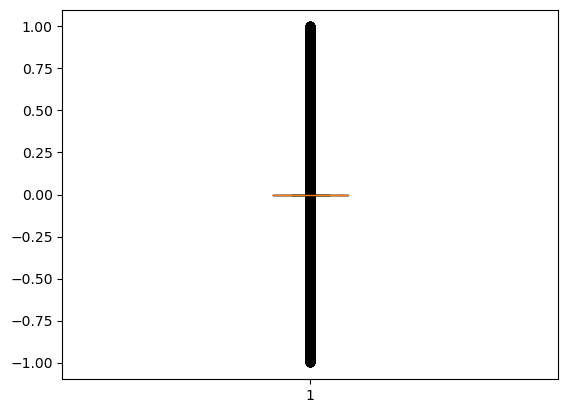

In [16]:
plt.boxplot(commits['sentiment'])

<Axes: xlabel='is_core', ylabel='sentiment'>

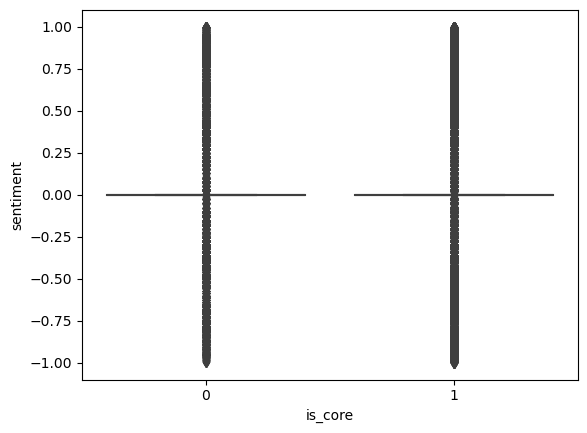

In [17]:
sns.boxplot(x='is_core', y='sentiment', data=commits)

In [18]:
non_zero = commits[commits['sentiment'] != 0]

In [19]:
non_zero

,name_with_owner,author,message,is_core,Cluster,processed_message,sentiment
6,xamarin/xamarin-macios,rolfbjarne,[xharness] Add support for enabling/disabling ...,1,2,xhar add support enabl disabl simul devic test,0.4019
18,yuzu-emu/yuzu,lioncash,kernel/svc: Implement svcGetThreadList\n\nSimi...,1,3,kernel svc implement svc get thread list simi...,-0.2263
19,microsoft/azuredatastudio,YurongHe,Fixed #3954 pass connection info to new notebo...,0,2,fix pass connect info new notebook flow f...,-0.4019
31,Hamlib/Hamlib,mdblack98,Fix ft1000d WRITE_DELAY as 175ms was unnecessary,1,1,fix write delay unnecessari,-0.3182
32,weseek/growi,yuki-takei,Merge pull request #429 from kaishuu0123/suppo...,1,1,merg pull request support addbluenightthem ad...,0.4019
...,...,...,...,...,...,...,...
458399,PhantomBot/PhantomBot,therentabrain,"fix typo, wrong function\n\nI had copied and p...",0,1,fix typo wrong function i copi past wrong fun...,-0.7351
458402,weaviate/weaviate,abdelr,Using distortion,0,1,use distort,-0.3182
458411,netbox-community/netbox,abhi1693,Adds full_clean in examples (#12527)\n\n* adds...,0,3,add full clean exampl add full clean examp...,0.6597
458418,postmanlabs/postman-docs,jkonrath-postman,Change supported frameworks,1,1,chang support framework,0.4019


<Axes: xlabel='is_core', ylabel='sentiment'>

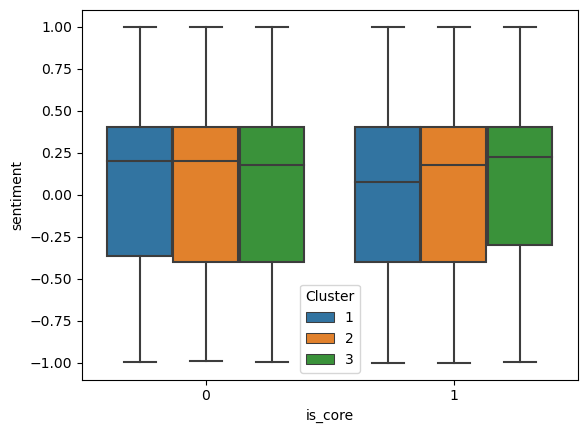

In [20]:
sns.boxplot(x='is_core', y='sentiment', hue = 'Cluster', data=non_zero)

<Axes: xlabel='is_core', ylabel='sentiment'>

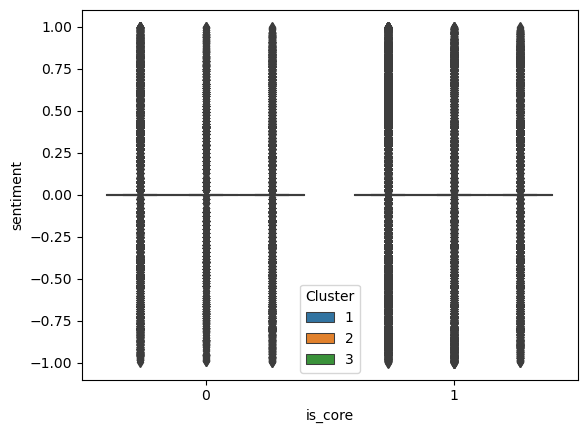

In [21]:
sns.boxplot(x='is_core', y='sentiment', hue = 'Cluster', data=commits)

In [22]:
c1 = commits[commits['Cluster'] == 1]
c2 = commits[commits['Cluster'] == 2]
c3 = commits[commits['Cluster'] == 3]

c1['is_core'].value_counts()

1    250208
0     82751
Name: is_core, dtype: int64

In [23]:
c2['is_core'].value_counts()

1    24115
0     5542
Name: is_core, dtype: int64

In [24]:
c3['is_core'].value_counts()

1    71001
0    22772
Name: is_core, dtype: int64

In [25]:
X_train, X_test, y_train, y_test = train_test_split(c1['processed_message'], c1['is_core'], test_size=0.8, random_state=42)

# Create a Bag of Words model
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

# Train a classifier (Naive Bayes in this case)
classifier = MultinomialNB()
classifier.fit(X_train_bow, y_train)

# Make predictions on the test set
predictions = classifier.predict(X_test_bow)

# Evaluate the performance
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.2f}")

# Display classification report
print("Classification Report:")
print(classification_report(y_test, predictions))

Accuracy: 0.78
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.31      0.42     66230
           1       0.81      0.94      0.87    200138

    accuracy                           0.78    266368
   macro avg       0.72      0.63      0.64    266368
weighted avg       0.76      0.78      0.76    266368



In [26]:
X_train, X_test, y_train, y_test = train_test_split(c2['processed_message'], c2['is_core'], test_size=0.8, random_state=42)

# Create a Bag of Words model
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

# Train a classifier (Naive Bayes in this case)
classifier = MultinomialNB()
classifier.fit(X_train_bow, y_train)

# Make predictions on the test set
predictions = classifier.predict(X_test_bow)

# Evaluate the performance
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.2f}")

# Display classification report
print("Classification Report:")
print(classification_report(y_test, predictions))

Accuracy: 0.80
Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.39      0.42      4452
           1       0.86      0.89      0.88     19274

    accuracy                           0.80     23726
   macro avg       0.66      0.64      0.65     23726
weighted avg       0.79      0.80      0.79     23726



In [27]:
X_train, X_test, y_train, y_test = train_test_split(c3['processed_message'], c3['is_core'], test_size=0.8, random_state=42)

# Create a Bag of Words model
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

# Train a classifier (Naive Bayes in this case)
classifier = MultinomialNB()
classifier.fit(X_train_bow, y_train)

# Make predictions on the test set
predictions = classifier.predict(X_test_bow)

# Evaluate the performance
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.2f}")

# Display classification report
print("Classification Report:")
print(classification_report(y_test, predictions))

Accuracy: 0.80
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.40      0.49     18186
           1       0.83      0.93      0.88     56833

    accuracy                           0.80     75019
   macro avg       0.74      0.66      0.68     75019
weighted avg       0.78      0.80      0.78     75019



In [28]:
c1

,name_with_owner,author,message,is_core,Cluster,processed_message,sentiment
1,SamR1/FitTrackee,SamR1,store user picture w/ relative path instead of...,1,1,store user pictur w rel path instead absolut path,0.0
4,pmmp/PocketMine-MP,dktapps,Plugin: Fixed return type documentation for ge...,1,1,plugin fix return type document get resourc,0.0
5,weseek/growi,yuki-takei,Merge remote-tracking branch 'origin/master' i...,1,1,merg remotetrack branch origin master rc,0.0
7,relative-ci/bundle-stats,vio,Merge pull request #74 from relative-ci/update...,1,1,merg pull request relativeci updateui updat ui,0.0
8,KhronosGroup/glTF-Blender-IO,scurest,Bugfix: exception on files with no meshes,0,1,bugfix except file mesh,0.0
...,...,...,...,...,...,...,...
458446,weaviate/weaviate,parkerduckworth,working gql Aggregate{},0,1,work gql aggreg,0.0
458447,postmanlabs/postman-docs,mark-anthony-postman,Add embedding a video,1,1,add embed video,0.0
458448,archesproject/arches,chrabyrd,Merge branch 'dev/7.5.x' of https://github.com...,1,1,merg branch dev x http github com archesproj...,0.0
458449,weaviate/weaviate,asdine,reduce duplicate lines,0,1,reduc duplic line,0.0


In [29]:
def balance_binary_class(df, binary_variable):
    np.random.seed(0)
    scores_acc = []
    scores_apre = []
    for i in range(100):
        # Identify the minority and majority classes based on counts
        class_counts = df[binary_variable].value_counts()
        minority_class = class_counts.idxmin()
        majority_class = class_counts.idxmax()

        # Separate the data into minority and majority classes
        minority_data = df[df[binary_variable] == minority_class]
        majority_data = df[df[binary_variable] == majority_class]

        # Sample an equal-sized random subset from the majority class
        majority_sample = majority_data.sample(n=len(minority_data))

        # Concatenate the minority samples and the randomly sampled majority samples
        balanced_data = pd.concat([minority_data, majority_sample], ignore_index=True)
        idx = -1
        
        # Vectorize the data using CountVectorizer
        vectorizer = CountVectorizer()
        X_bow = vectorizer.fit_transform(balanced_data['processed_message'])
        y = balanced_data['is_core']

        # Initialize a Multinomial Naive Bayes classifier
        classifier = MultinomialNB()

        # Define 10-fold cross-validation
        kf = KFold(n_splits=10, shuffle=True)

        # Perform 10-fold cross-validation and get predictions
        predictions = cross_val_score(classifier, X_bow, y, cv=kf, scoring='accuracy')
        predictions2 = cross_val_score(classifier, X_bow, y, cv=kf, scoring='f1')
        for pred in predictions:
            scores_acc.append(pred)
        for pred in predictions2:
            scores_apre.append(pred)
    return scores_acc, scores_apre

# Example usage:
# Assuming 'binary_variable' is the name of your binary variable
c1_acc, c1_apre = balance_binary_class(c1, 'is_core')
c2_acc, c2_apre = balance_binary_class(c2, 'is_core')
c3_acc, c3_apre = balance_binary_class(c3, 'is_core')

In [30]:
# Initialize the column names and corresponding empty lists
columns = ['Score', 'Metric', 'Cluster']
data = {col: [] for col in columns}

# Create an empty DataFrame
scores = pd.DataFrame(data)

for row in c1_acc:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [0], 'Cluster': [1]})
    scores = pd.concat([scores, new_row], ignore_index=True)
    
for row in c2_acc:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [0], 'Cluster': [2]})
    scores = pd.concat([scores, new_row], ignore_index=True)
    
for row in c3_acc:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [0], 'Cluster': [3]})
    scores = pd.concat([scores, new_row], ignore_index=True)
    
for row in c1_apre:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [1], 'Cluster': [1]})
    scores = pd.concat([scores, new_row], ignore_index=True)
      
for row in c2_apre:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [1], 'Cluster': [2]})
    scores = pd.concat([scores, new_row], ignore_index=True)
    
for row in c3_apre:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [1], 'Cluster': [3]})
    scores = pd.concat([scores, new_row], ignore_index=True)

In [31]:
def balance_binary_class_tf_idf(df, binary_variable):
    np.random.seed(0)
    scores_acc = []
    scores_apre = []
    
    for i in range(100):
        # Identify the minority and majority classes based on counts
        class_counts = df[binary_variable].value_counts()
        minority_class = class_counts.idxmin()
        majority_class = class_counts.idxmax()

        # Separate the data into minority and majority classes
        minority_data = df[df[binary_variable] == minority_class]
        majority_data = df[df[binary_variable] == majority_class]

        # Sample an equal-sized random subset from the majority class
        majority_sample = majority_data.sample(n=len(minority_data))

        # Concatenate the minority samples and the randomly sampled majority samples
        balanced_data = pd.concat([minority_data, majority_sample], ignore_index=True)
        
        # Vectorize the data using TfidfVectorizer
        vectorizer = TfidfVectorizer()
        X_tfidf = vectorizer.fit_transform(balanced_data['processed_message'])
        y = balanced_data['is_core']

        # Initialize a Multinomial Naive Bayes classifier
        classifier = MultinomialNB()

        # Define 10-fold cross-validation
        kf = KFold(n_splits=10, shuffle=True, random_state=42)

        # Perform 10-fold cross-validation and get predictions
        predictions = cross_val_score(classifier, X_tfidf, y, cv=kf, scoring='accuracy')
        predictions2 = cross_val_score(classifier, X_tfidf, y, cv=kf, scoring='f1')
        
        scores_acc.extend(predictions)
        scores_apre.extend(predictions2)
        
    return scores_acc, scores_apre


# Example usage:
# Assuming 'binary_variable' is the name of your binary variable
c1_acc_idf, c1_apre_idf = balance_binary_class_tf_idf(c1, 'is_core')
c2_acc_idf, c2_apre_idf = balance_binary_class_tf_idf(c2, 'is_core')
c3_acc_idf, c3_apre_idf = balance_binary_class_tf_idf(c3, 'is_core')

In [32]:
# Initialize the column names and corresponding empty lists
columns = ['Score', 'Metric', 'Cluster']
data = {col: [] for col in columns}

# Create an empty DataFrame
scores_idf = pd.DataFrame(data)

for row in c1_acc_idf:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [0], 'Cluster': [1]})
    scores_idf = pd.concat([scores_idf, new_row], ignore_index=True)
    
for row in c2_acc_idf:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [0], 'Cluster': [2]})
    scores_idf = pd.concat([scores_idf, new_row], ignore_index=True)
    
for row in c3_acc_idf:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [0], 'Cluster': [3]})
    scores_idf = pd.concat([scores_idf, new_row], ignore_index=True)
    
for row in c1_apre_idf:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [1], 'Cluster': [1]})
    scores_idf = pd.concat([scores_idf, new_row], ignore_index=True)
      
for row in c2_apre_idf:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [1], 'Cluster': [2]})
    scores_idf = pd.concat([scores_idf, new_row], ignore_index=True)
    
for row in c3_apre_idf:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [1], 'Cluster': [3]})
    scores_idf = pd.concat([scores_idf, new_row], ignore_index=True)

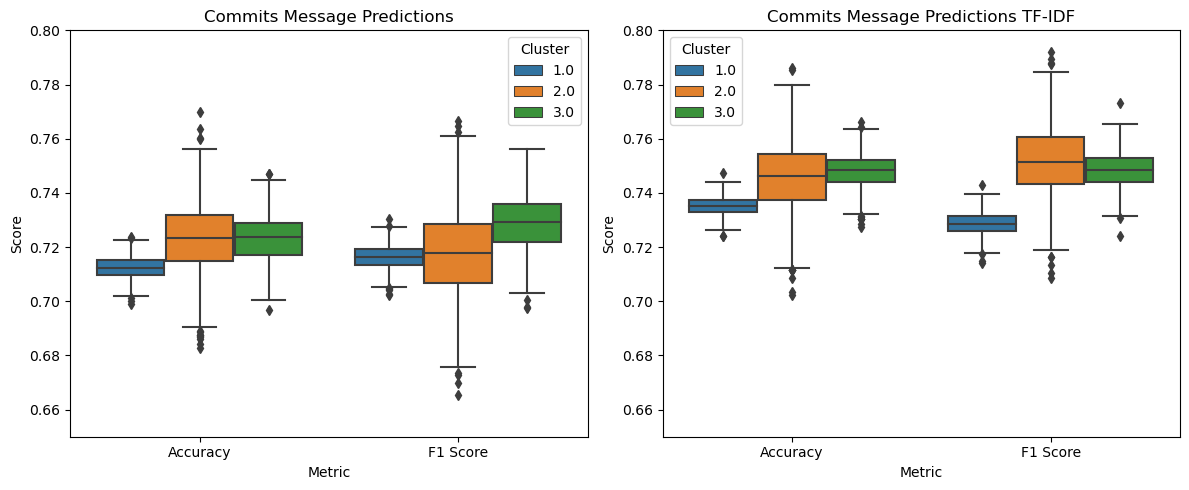

In [33]:
# Create a subplot grid
new_xtick_labels = ['Accuracy', 'F1 Score']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plot the first boxplot
sns.boxplot(x='Metric', y='Score', hue='Cluster', data=scores, ax=axes[0])
axes[0].set_title('Commits Message Predictions')
axes[0].set_xticks(range(len(new_xtick_labels)))  # Set x-axis ticks
axes[0].set_xticklabels(new_xtick_labels) 
axes[0].set_ylim(0.65, 0.8)

# Plot the second boxplot
sns.boxplot(x='Metric', y='Score', hue='Cluster', data=scores_idf, ax=axes[1])
axes[1].set_title('Commits Message Predictions TF-IDF')
axes[1].set_xticks(range(len(new_xtick_labels)))  # Set x-axis ticks
axes[1].set_xticklabels(new_xtick_labels) 
axes[1].set_ylim(0.65, 0.8)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [44]:
# Initialize the column names and corresponding empty lists
columns = ['Score', 'Metric', 'Cluster']
data = {col: [] for col in columns}

# Create an empty DataFrame
accuracy = pd.DataFrame(data)

for row in c1_acc:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [0], 'Cluster': [1]})
    accuracy = pd.concat([accuracy, new_row], ignore_index=True)
    
for row in c2_acc:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [0], 'Cluster': [2]})
    accuracy = pd.concat([accuracy, new_row], ignore_index=True)
    
for row in c3_acc:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [0], 'Cluster': [3]})
    accuracy = pd.concat([accuracy, new_row], ignore_index=True)
    
for row in c1_acc_idf:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [1], 'Cluster': [1]})
    accuracy = pd.concat([accuracy, new_row], ignore_index=True)
      
for row in c1_acc_idf:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [1], 'Cluster': [2]})
    accuracy = pd.concat([accuracy, new_row], ignore_index=True)
    
for row in c1_acc_idf:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [1], 'Cluster': [3]})
    accuracy = pd.concat([accuracy, new_row], ignore_index=True)

In [45]:
# Initialize the column names and corresponding empty lists
columns = ['Score', 'Metric', 'Cluster']
data = {col: [] for col in columns}

# Create an empty DataFrame
f1 = pd.DataFrame(data)

for row in c1_apre:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [0], 'Cluster': [1]})
    f1 = pd.concat([f1, new_row], ignore_index=True)
    
for row in c2_apre:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [0], 'Cluster': [2]})
    f1 = pd.concat([f1, new_row], ignore_index=True)
    
for row in c3_apre:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [0], 'Cluster': [3]})
    f1 = pd.concat([f1, new_row], ignore_index=True)
    
for row in c1_apre_idf:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [1], 'Cluster': [1]})
    f1 = pd.concat([f1, new_row], ignore_index=True)
      
for row in c2_apre_idf:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [1], 'Cluster': [2]})
    f1 = pd.concat([f1, new_row], ignore_index=True)
    
for row in c3_apre_idf:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [1], 'Cluster': [3]})
    f1 = pd.concat([f1, new_row], ignore_index=True)

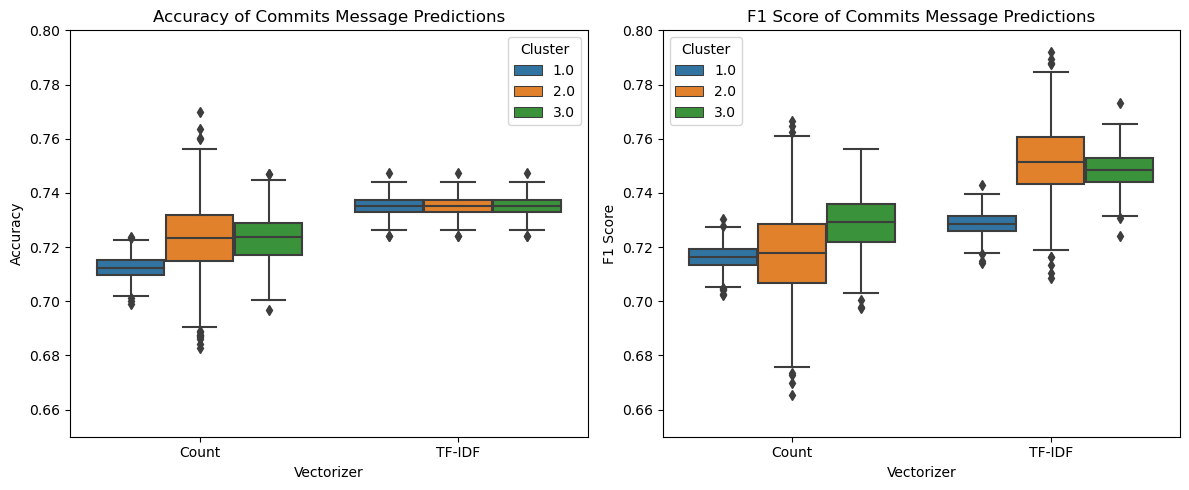

In [46]:
# Create a subplot grid
new_xtick_labels = ['Count', 'TF-IDF']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plot the first boxplot
sns.boxplot(x='Metric', y='Score', hue='Cluster', data=accuracy, ax=axes[0])
axes[0].set_title('Accuracy of Commits Message Predictions')
axes[0].set_xticks(range(len(new_xtick_labels)))  # Set x-axis ticks
axes[0].set_xticklabels(new_xtick_labels) 
axes[0].set_ylim(0.65, 0.8)
axes[0].set_xlabel("Vectorizer")
axes[0].set_ylabel("Accuracy")

# Plot the second boxplot
sns.boxplot(x='Metric', y='Score', hue='Cluster', data=f1, ax=axes[1])
axes[1].set_title('F1 Score of Commits Message Predictions')
axes[1].set_xticks(range(len(new_xtick_labels)))  # Set x-axis ticks
axes[1].set_xticklabels(new_xtick_labels) 
axes[1].set_ylim(0.65, 0.8)
axes[1].set_xlabel("Vectorizer")
axes[1].set_ylabel("F1 Score")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [37]:
vectorizer = CountVectorizer()
core_titles = commits[commits['is_core'] == 1]
title_words = vectorizer.fit_transform(core_titles['processed_message'])

# Get feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Sum the counts across all documents
word_counts = title_words.sum(axis=0)

# Create a DataFrame to display the top 25 most common words with counts
top_words_df = pd.DataFrame({'Word': feature_names, 'Count': word_counts.tolist()[0]})
top_words_df = top_words_df.sort_values(by='Count', ascending=False).head(50)

# Display the top 25 most common words
print(top_words_df)

               Word  Count
21293           fix  98441
37158          merg  73547
65298         updat  69563
11199           com  62724
570             add  56861
51623       request  51802
48207          pull  50358
56080   signedoffbi  39082
61211          test  33447
66195           use  29160
50844         remov  26084
25385        github  26030
6920         branch  22633
28228          http  20918
8901          chang  17744
20974          file  16720
530              ad  15923
42667        nvidia  14835
25700         gmail  14789
40382           new  14713
19163         error  14147
50661        releas  14026
59822       support  13860
55093           set  13786
36504        master  13658
10874          code  12719
20586          feat  12653
31213          issu  12285
67236       version  12252
7381          build  11629
16436           doc  11575
66355          user  11487
63765          type  11378
7581           bump  11063
36827            md  10914
25110           get  10242
6

In [43]:
accuracy

,Score,Metric,Cluster
